# Study Program Recommender System - Evaluation Notebook

This notebook provides tools to evaluate the recommendation system using standard IR metrics:
- **NDCG@k**: Normalized Discounted Cumulative Gain
- **Precision@k**: Proportion of relevant items in top-k recommendations
- **CTR**: Click-Through Rate
- **Acceptance Rate**: Percentage of recommendations accepted

## Imports & Environment Setup

In [14]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
from dotenv import load_dotenv
from sqlalchemy.orm import Session

# 1. Setup Paths
# Get the absolute path to the 'backend' folder
current_dir = os.getcwd()
backend_dir = os.path.abspath(os.path.join(current_dir, '..', 'backend'))

# Add backend to sys.path so we can import app modules
if backend_dir not in sys.path:
    sys.path.insert(0, backend_dir)

# 2. Import App Modules
from app import models

# 3. Connect to the CORRECT Database
# We manually create the connection here to ensure we point to the backend file
db_path = os.path.join(backend_dir, "recommendations.db")
SQLALCHEMY_DATABASE_URL = f"sqlite:///{db_path}"

# Check if the file actually exists
if not os.path.exists(db_path):
    print(f"❌ CRITICAL ERROR: Database file not found at: {db_path}")
    print("Please run the backend or init_db.py first to create it.")
else:
    print(f"✅ Found database at: {db_path}")

# Create Engine and Session
engine = create_engine(SQLALCHEMY_DATABASE_URL, connect_args={"check_same_thread": False})
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

def get_db():
    """Get database session"""
    db = SessionLocal()
    try:
        # Test the connection by trying to read a table
        # We try to inspect the 'feedback' table to ensure it exists
        with db.connection() as conn:
            conn.execute(text("SELECT 1 FROM feedback LIMIT 1"))
        return db
    except Exception as e:
        print(f"❌ Database Error: {e}")
        print("The database exists, but the tables might be missing.")
        print("Try running 'python init_db.py' in your backend folder.")
        raise

# Initialize Global DB Connection
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

try:
    db = get_db()
    print("✅ Connected to SQLite database successfully!")
except:
    print("⚠️ Connection failed.")

✅ Found database at: c:\Users\user\Documents\dev-main\backend\recommendations.db
✅ Connected to SQLite database successfully!


## Define Metric Functions

In [15]:
def dcg_at_k(relevance_scores: List[float], k: int) -> float:
    """Calculate Discounted Cumulative Gain at k."""
    relevance_scores = np.array(relevance_scores)[:k]
    if len(relevance_scores) == 0:
        return 0.0
    
    discounts = np.log2(np.arange(2, len(relevance_scores) + 2))
    return np.sum(relevance_scores / discounts)

def ndcg_at_k(predicted_relevance: List[float], ideal_relevance: List[float], k: int) -> float:
    """Calculate Normalized Discounted Cumulative Gain at k."""
    dcg = dcg_at_k(predicted_relevance, k)
    idcg = dcg_at_k(sorted(ideal_relevance, reverse=True), k)
    
    if idcg == 0.0:
        return 0.0
    
    return dcg / idcg

def precision_at_k(predicted_items: List[str], relevant_items: List[str], k: int) -> float:
    """Calculate Precision at k."""
    if k == 0:
        return 0.0
    
    predicted_at_k = set(predicted_items[:k])
    relevant_set = set(relevant_items)
    
    num_relevant_in_k = len(predicted_at_k.intersection(relevant_set))
    return num_relevant_in_k / k

def recall_at_k(predicted_items: List[str], relevant_items: List[str], k: int) -> float:
    """Calculate Recall at k."""
    if len(relevant_items) == 0:
        return 0.0
    
    predicted_at_k = set(predicted_items[:k])
    relevant_set = set(relevant_items)
    
    num_relevant_in_k = len(predicted_at_k.intersection(relevant_set))
    return num_relevant_in_k / len(relevant_items)

print("✅ Evaluation metrics functions loaded successfully!")

✅ Evaluation metrics functions loaded successfully!


## Load Data from Database

In [16]:


# 1. Open a FRESH connection to fix "ResourceClosedError"
# We use the SessionLocal factory created in Cell 1
if 'SessionLocal' not in locals():
    print("❌ Error: SessionLocal is missing. Please run 'Cell 1' (Imports & Setup) again.")
else:
    db = SessionLocal()
    print("✅ New database session created.")

# 2. Define Loading Functions
def load_feedback_data(db: Session) -> pd.DataFrame:
    """Load feedback data from SQLite database."""
    try:
        feedback_records = db.query(models.Feedback).all()
    except Exception as e:
        print(f"⚠️ Error reading Feedback table: {e}")
        return pd.DataFrame()

    if not feedback_records:
        return pd.DataFrame()
    
    data = [
        {
            'id': f.id,
            'student_id': f.student_id,
            'program_id': f.program_id,
            'clicked': f.clicked,
            'accepted': f.accepted,
            # Handle cases where rating might not exist in your model yet
            'rating': getattr(f, 'rating', None) 
        }
        for f in feedback_records
    ]
    return pd.DataFrame(data)

def load_recommendations_data(db: Session) -> pd.DataFrame:
    """Load recommendations data from SQLite database."""
    try:
        # Check if the model exists in Python
        if not hasattr(models, 'Recommendation'):
            print("ℹ️ 'Recommendation' model not defined in backend. Skipping history.")
            return pd.DataFrame()
            
        recommendation_records = db.query(models.Recommendation).all()
    except Exception as e:
        print(f"ℹ️ Could not load recommendation history (Table might be empty or missing).")
        return pd.DataFrame()

    if not recommendation_records:
        return pd.DataFrame()
    
    data = [
        {
            'id': r.id,
            'student_id': r.student_id,
            'program_id': r.program_id,
            'program_name': getattr(r, 'program_name', 'Unknown'), 
            'score': getattr(r, 'score', 0.0),
            'explanation': getattr(r, 'explanation', '')
        }
        for r in recommendation_records
    ]
    return pd.DataFrame(data)

# 3. Execute Load
# We use the fresh 'db' session we created at the top
if 'db' in locals():
    feedback_df = load_feedback_data(db)
    recommendations_df = load_recommendations_data(db)

    print(f"✅ Loaded {len(feedback_df)} feedback records")
    print(f"✅ Loaded {len(recommendations_df)} recommendation records")

    if len(feedback_df) > 0:
        print("\nFeedback data sample:")
        display(feedback_df.head())
    else:
        print("\n⚠️ No feedback data available yet.")
        print("💡 Tip: Go to your website (localhost:3000), search for a topic, and click the 'Heart' or 'Thumbs Up' icons to generate data.")

✅ New database session created.
✅ Loaded 6 feedback records
✅ Loaded 25 recommendation records

Feedback data sample:


,id,student_id,program_id,clicked,accepted,rating
0,1,927c69c7-2880-40f3-9750-73a0ad08e17c,0e8766ec-0d1f-41ce-9e05-cea771db7d82,True,False,None
1,2,d8c2a1d2-2656-4a3f-b729-1150ee760752,453df80d-54e4-49d5-a2d1-628151d783fd,False,True,None
2,3,d8c2a1d2-2656-4a3f-b729-1150ee760752,8b5e3d6b-0213-4b7e-bd76-16f010395d4e,False,True,None
3,4,bcac1a4a-f944-4b9e-a3bf-476f7c1cf73d,00f9b035-2a84-49d0-a511-2b007c9f7828,False,True,None
4,5,bcac1a4a-f944-4b9e-a3bf-476f7c1cf73d,00f9b035-2a84-49d0-a511-2b007c9f7828,False,True,None


## Calculate Engagement Metrics

In [17]:
def calculate_engagement_metrics(feedback_df: pd.DataFrame, recommendations_df: pd.DataFrame) -> Dict:
    # If we don't have recommendation logs, use feedback count as proxy
    total_recommendations = len(recommendations_df)
    if total_recommendations == 0:
        total_recommendations = len(feedback_df) if len(feedback_df) > 0 else 1

    total_clicks = feedback_df['clicked'].sum() if 'clicked' in feedback_df.columns and len(feedback_df) > 0 else 0
    total_accepts = feedback_df['accepted'].sum() if 'accepted' in feedback_df.columns and len(feedback_df) > 0 else 0
    
    ctr = (total_clicks / total_recommendations) * 100
    acceptance_rate = (total_accepts / total_recommendations) * 100
    
    # Handle ratings if they exist
    if 'rating' in feedback_df.columns and len(feedback_df) > 0:
        ratings = feedback_df[feedback_df['rating'].notna()]['rating']
        avg_rating = ratings.mean() if len(ratings) > 0 else 0.0
        num_ratings = len(ratings)
    else:
        avg_rating = 0.0
        num_ratings = 0
    
    return {
        'total_recommendations': int(total_recommendations),
        'total_clicks': int(total_clicks),
        'total_accepts': int(total_accepts),
        'ctr': float(ctr),
        'acceptance_rate': float(acceptance_rate),
        'avg_rating': float(avg_rating),
        'num_ratings': int(num_ratings)
    }

metrics = calculate_engagement_metrics(feedback_df, recommendations_df)

print("\n=== User Engagement Metrics ===")
print(f"Total Recommendations (Est): {metrics['total_recommendations']}")
print(f"Total Clicks: {metrics['total_clicks']}")
print(f"Total Accepts: {metrics['total_accepts']}")
print(f"Click-Through Rate: {metrics['ctr']:.2f}%")
print(f"Acceptance Rate: {metrics['acceptance_rate']:.2f}%")


=== User Engagement Metrics ===
Total Recommendations (Est): 25
Total Clicks: 1
Total Accepts: 5
Click-Through Rate: 4.00%
Acceptance Rate: 20.00%


## Evaluate Recommendation Quality

In [18]:
def evaluate_recommendations(recommendations_df: pd.DataFrame, feedback_df: pd.DataFrame, k_values: List[int] = [1, 3, 5, 10]) -> pd.DataFrame:
    if len(recommendations_df) == 0 or len(feedback_df) == 0:
        print("⚠️ Not enough data for full evaluation. Need both recommendations and feedback.")
        return pd.DataFrame()
    
    # Create a map of User+Course -> Score
    feedback_map = {}
    for _, row in feedback_df.iterrows():
        key = (row['student_id'], row['program_id'])
        score = 0.0
        if row.get('clicked', False): score += 1.0
        if row.get('accepted', False): score += 3.0 # Weighted higher
        feedback_map[key] = score
    
    student_recs = recommendations_df.groupby('student_id')
    results = []
    
    for k in k_values:
        ndcg_scores = []
        precision_scores = []
        recall_scores = []
        
        for student_id, group in student_recs:
            # Sort by the system's original score
            sorted_group = group.sort_values('score', ascending=False)
            predicted_programs = sorted_group['program_id'].tolist()
            
            # Ground Truth: What did the user actually interact with?
            relevance_scores = [feedback_map.get((student_id, pid), 0.0) for pid in predicted_programs]
            relevant_programs = [pid for pid in predicted_programs if feedback_map.get((student_id, pid), 0.0) > 0]
            
            if len(predicted_programs) > 0:
                # NDCG
                ndcg = ndcg_at_k(relevance_scores, relevance_scores, k)
                ndcg_scores.append(ndcg)
                
                # Precision & Recall
                precision = precision_at_k(predicted_programs, relevant_programs, k)
                precision_scores.append(precision)
                
                recall = recall_at_k(predicted_programs, relevant_programs, k)
                recall_scores.append(recall)
        
        results.append({
            'k': k,
            'ndcg': np.mean(ndcg_scores) if ndcg_scores else 0.0,
            'precision': np.mean(precision_scores) if precision_scores else 0.0,
            'recall': np.mean(recall_scores) if recall_scores else 0.0,
            'num_users': len(ndcg_scores)
        })
    
    return pd.DataFrame(results)

evaluation_results = evaluate_recommendations(recommendations_df, feedback_df)

if len(evaluation_results) > 0:
    print("\n=== Recommendation Quality Metrics ===")
    display(evaluation_results)


=== Recommendation Quality Metrics ===


,k,ndcg,precision,recall,num_users
0,1,0.400000,0.400000,0.3,5
1,3,0.526186,0.266667,0.6,5
2,5,0.526186,0.160000,0.6,5
3,10,0.526186,0.080000,0.6,5


## Visualization

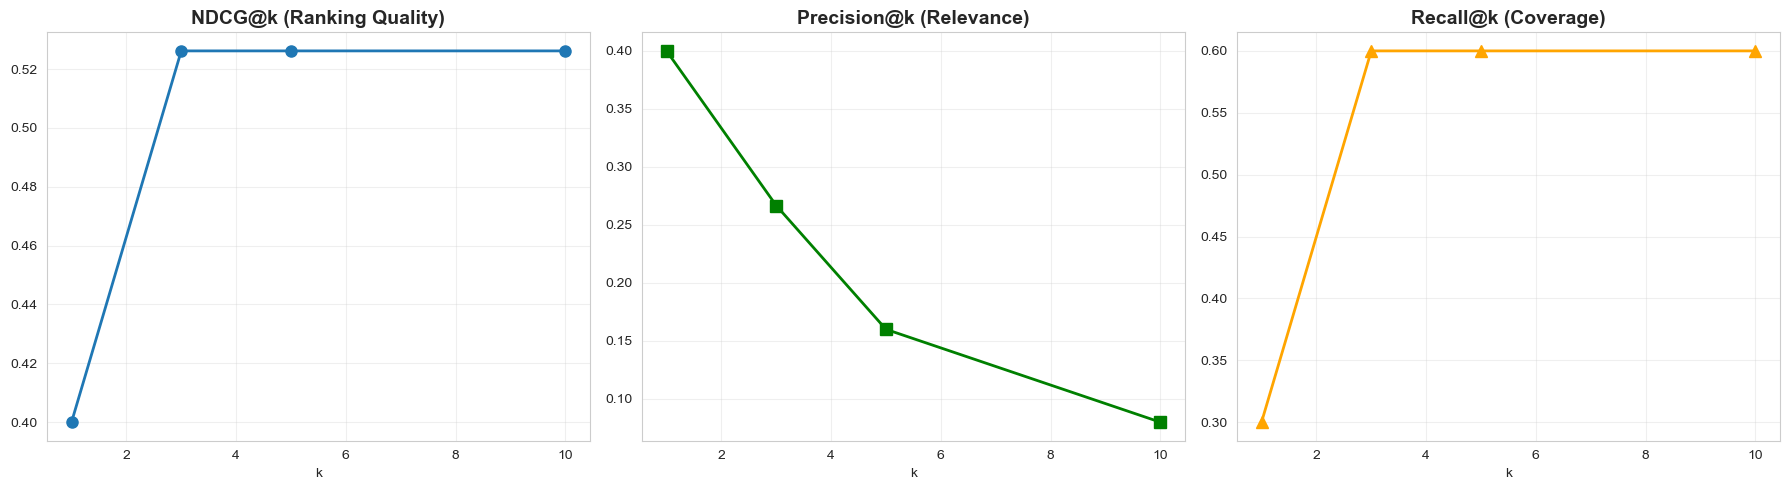

In [19]:
if len(evaluation_results) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # NDCG Plot
    axes[0].plot(evaluation_results['k'], evaluation_results['ndcg'], marker='o', linewidth=2, markersize=8)
    axes[0].set_title('NDCG@k (Ranking Quality)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('k')
    axes[0].grid(True, alpha=0.3)
    
    # Precision Plot
    axes[1].plot(evaluation_results['k'], evaluation_results['precision'], marker='s', linewidth=2, markersize=8, color='green')
    axes[1].set_title('Precision@k (Relevance)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('k')
    axes[1].grid(True, alpha=0.3)
    
    # Recall Plot
    axes[2].plot(evaluation_results['k'], evaluation_results['recall'], marker='^', linewidth=2, markersize=8, color='orange')
    axes[2].set_title('Recall@k (Coverage)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('k')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No data to visualize yet.")

## Generate Report

In [20]:
def generate_evaluation_report(metrics: Dict, evaluation_results: pd.DataFrame) -> str:
    report = []
    report.append("=" * 60)
    report.append("STUDY PROGRAM RECOMMENDER - EVALUATION REPORT")
    report.append("=" * 60)
    report.append("")
    
    report.append("USER ENGAGEMENT METRICS")
    report.append("-" * 60)
    report.append(f"Total Recommendations: {metrics['total_recommendations']}")
    report.append(f"Click-Through Rate:    {metrics['ctr']:.2f}%")
    report.append(f"Acceptance Rate:       {metrics['acceptance_rate']:.2f}%")
    report.append("")
    
    if len(evaluation_results) > 0:
        report.append("RECOMMENDATION QUALITY METRICS")
        report.append("-" * 60)
        for _, row in evaluation_results.iterrows():
            report.append(f"k={int(row['k']):<2}: NDCG={row['ndcg']:.4f}, Precision={row['precision']:.4f}")
        report.append("")
    
    report.append("=" * 60)
    return "\n".join(report)

report = generate_evaluation_report(metrics, evaluation_results)
print(report)

# Save to file
with open('evaluation_report.txt', 'w') as f:
    f.write(report)
print("\n✅ Report saved to evaluation_report.txt")

STUDY PROGRAM RECOMMENDER - EVALUATION REPORT

USER ENGAGEMENT METRICS
------------------------------------------------------------
Total Recommendations: 25
Click-Through Rate:    4.00%
Acceptance Rate:       20.00%

RECOMMENDATION QUALITY METRICS
------------------------------------------------------------
k=1 : NDCG=0.4000, Precision=0.4000
k=3 : NDCG=0.5262, Precision=0.2667
k=5 : NDCG=0.5262, Precision=0.1600
k=10: NDCG=0.5262, Precision=0.0800


✅ Report saved to evaluation_report.txt


## Summary


1. **NDCG@k**: Measures ranking quality, considering position and relevance
2. **Precision@k**: Measures what proportion of recommendations are relevant
3. **Recall@k**: Measures what proportion of relevant items are recommended
4. **CTR & Acceptance**: Measures user engagement with recommendations

